In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyvi

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import digits
from collections import Counter
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
# from tensorflow.keras.utils.np_utils import to_categorical
%matplotlib inline

In [4]:
data_train = pd.read_csv("/content/drive/MyDrive/longdoc_sentimentAnalysis/data_preprocessing/train.csv",index_col=False)
data_test = pd.read_csv("/content/drive/MyDrive/longdoc_sentimentAnalysis/data_preprocessing/test.csv",index_col=False)

<Axes: >

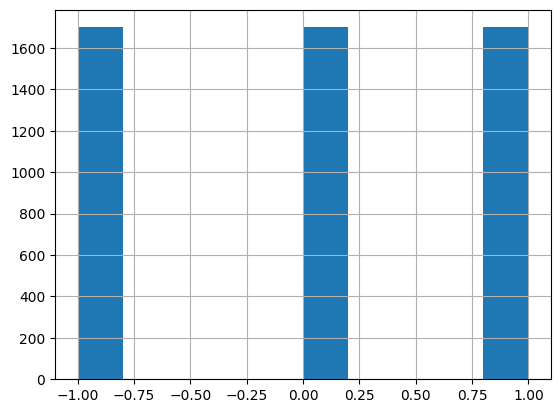

In [5]:
data_train['Class'].hist()

In [6]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, auc, roc_curve, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb

#use for LSTM and WordEmbedding Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional
from tensorflow.keras.layers import Embedding,SpatialDropout1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.initializers import Constant

**Metric**

In [7]:
def calculate_metrics(X_test_scaled, Y_test,model = None,naive = False):
    # Get model predictions
    if model:
       y_predict_r = model.predict(X_test_scaled)
    elif naive == True:
      _,y_predict_r = test_naive_bayes(X_test_scaled,Y_test,log_prior,log_likelihood)
    else:
       y_predict_r = X_test_scaled
    # Calculate evaluation metrics for assesing performance of the model.
    # roc=roc_auc_score(Y_test, y_predict_r)
    acc = accuracy_score(Y_test, y_predict_r)
    prec = precision_score(Y_test, y_predict_r, average='macro')
    rec = recall_score(Y_test, y_predict_r, average='macro')
    f1 = f1_score(Y_test, y_predict_r, average='macro')

    return acc, prec, rec, f1

def get_metrics(X_test, Y_test, model = None, naive = False):
    # All features of dataset are float values. You normalize all features of the train and test dataset here.

    # Call the fit model function to train the model on the normalized features and the diagnosis values
    # Make predictions on test dataset and calculate metrics.

    acc, prec, rec, f1 = calculate_metrics(X_test, Y_test, model = model, naive = naive)

    display_df = pd.DataFrame([[acc, prec, rec, f1]], columns=["Accuracy", "Precision", "Recall", "F1 Score"])
    return display_df

In [8]:
X_train = data_train['text'].to_list()
X_test = data_test['text'].to_list()
y_train = data_train['Class'].to_list()
y_test = data_test['Class'].to_list()
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size=0.05,random_state=16)

#Method 1: naive bayes

In [9]:
import numpy as np

def count_tweets(tweets, ys):
    result = {}
    for y,tweet in zip(ys,tweets):
        lst_tweet = tweet.strip().split()
        for word in lst_tweet:
            tup = (word,y)
            if tup in result.keys():
               result[tup] += 1
            else:
               result[tup] = 1
    return result

def train_naive_bayes(freqs,train_x,train_y):
    loglikelihood = {}
    logprior = 0

    N_pos = 0
    N_neg = 0

    vocab = set([ele[0] for ele in freqs.keys()])

    for pair in freqs.keys():
        if pair[1] == 1:
           N_pos += freqs[pair]
        else:
           N_neg += freqs[pair]

    D = len(train_y) #number of sentences
    D_pos = np.sum(train_y == np.ones(len(train_y)))
    D_neg = D - D_pos

    V = len(vocab)
    log_prior = np.log(D_pos) - np.log(D_neg)
    log_likelihood = {}
    for word in vocab:
        freqs_pos = freqs.get((word,1),0)
        neg_pos = freqs.get((word,0),0)

        #smoothing
        freqs_pos_prob = (freqs_pos + 1)/(N_pos + V)
        freqs_neg_prob = (neg_pos + 1)/(N_neg + V)

        log_likelihood[word] = np.log(freqs_pos_prob) - np.log(freqs_neg_prob)

    return log_prior,log_likelihood

def naive_bayes_predict(tweet,log_prior,log_likelihood):
    tweet = tweet.strip().split()

    res = 0

    for word in tweet:
        if word in log_likelihood:
           res += log_likelihood[word]
    res += log_prior

    return res

def test_naive_bayes(test_x,test_y,log_prior,log_likelihood):
    y_hat = []
    for tweet in test_x:
        # print(tweet)
        res = naive_bayes_predict(tweet,log_prior,log_likelihood)
        if res >= 0.5:
           y_hat.append(1)
        elif res <= -0.5:
           y_hat.append(-1)
        else:
          y_hat.append(0)

    y_hat = np.array(y_hat)
    accuracy = np.sum(test_y == y_hat)/len(y_hat)
    return accuracy, y_hat

def predict(sentence,log_likelihood,log_prior):
    tweet = sentence.strip().split()

    res = 0

    for word in tweet:
        if word in log_likelihood:
           res += log_likelihood[word]

    res += log_prior
    if res >= 0:
       return "positive"
    return "negative"

In [10]:
freqs = count_tweets(X_train + X_val,y_train + y_val)
log_prior,log_likelihood = train_naive_bayes(freqs,X_train + X_val,y_train + y_val)

train_res,_ = test_naive_bayes(X_train + X_val,y_train + y_val,log_prior,log_likelihood)
test_res,y_hat = test_naive_bayes(X_test,y_test,log_prior,log_likelihood)

print('train_acc: ',train_res)
print('test_acc: ',test_res)

train_acc:  0.346078431372549
test_acc:  0.33904761904761904


In [11]:
all_features_eval_df = get_metrics(X_test, y_test, naive=True)
all_features_eval_df.index = ['Naive Bayes']

# Creating an empty DataFrame
results = pd.DataFrame({})

# Using pd.concat instead of append
results = pd.concat([results, all_features_eval_df])

# Display the last 10 rows
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.339048,0.287803,0.339048,0.187628


#Method 2: TF_IDF and Tokenizer method

In [12]:

from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(train, test):
    tf = TfidfVectorizer(ngram_range=(1, 5))
    tf.fit(train)
    train = tf.transform(train)
    test = tf.transform(test)
    return train, test


def tokenization(train, test, vocab_size, max_len):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(train)

    train = tokenizer.texts_to_sequences(train)
    test = tokenizer.texts_to_sequences(test)
    padded_train = pad_sequences(train, maxlen=max_len, padding='post', truncating='post')
    padded_test = pad_sequences(test, maxlen=max_len, padding='post', truncating='post')

    return padded_train, padded_test

In [13]:
class SA():
    def __init__(self, mode, vocab_size=10000, max_len=420, split=False, test_size=0.20588235294):
        self.X_train, self.Y_train = X_train + X_val, y_train + y_val
        self.X_test, self.Y_test = X_test, y_test

        if mode == 'tfidf':
            self.X_train, self.X_test = tfidf(self.X_train, self.X_test)
        elif mode == 'tokenization':
            self.X_train, self.X_test = tokenization(self.X_train, self.X_test, vocab_size, max_len)

        if split == True:
            self.X_train, self.X_valid, self.Y_train, self.Y_valid = train_test_split(self.X_train, self.Y_train,
                                                                                    test_size=test_size, shuffle=True, random_state=42)

**Tokenization**

In [14]:
ds = SA(mode='tokenization')

In [15]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier().fit(ds.X_train, ds.Y_train)
# sgd_prediction = sgd.predict(ds.X_test)

all_features_eval_df = get_metrics(ds.X_test, ds.Y_test, sgd)
all_features_eval_df.index = ['Tokenization_SGD']

# Using pd.concat instead of append
results = pd.concat([results, all_features_eval_df])

# Display the last 10 rows
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.339048,0.287803,0.339048,0.187628
Tokenization_SGD,0.313333,0.316661,0.313333,0.305519


In [16]:
from sklearn.svm import SVC
svc = SVC(C=1000).fit(ds.X_train, ds.Y_train)
# svc_prediction = svc.predict(ds.X_test)

all_features_eval_df = get_metrics(ds.X_test, ds.Y_test, svc)
all_features_eval_df.index = ['Tokenization_SVM']

# Using pd.concat instead of append
results = pd.concat([results, all_features_eval_df])

# Display the last 10 rows
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.339048,0.287803,0.339048,0.187628
Tokenization_SGD,0.313333,0.316661,0.313333,0.305519
Tokenization_SVM,0.376190,0.376952,0.376190,0.373842


**TF-IDF**

In [17]:
ds = SA(mode='tfidf')

In [18]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier().fit(ds.X_train, ds.Y_train)
# sgd_prediction = sgd.predict(ds.X_test)
# print(classification_report(ds.Y_test, sgd_prediction))

all_features_eval_df = get_metrics(ds.X_test, ds.Y_test, sgd)
all_features_eval_df.index = ['TF-IDF sgd']

# Using pd.concat instead of append
results = pd.concat([results, all_features_eval_df])

# Display the last 10 rows
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.339048,0.287803,0.339048,0.187628
Tokenization_SGD,0.313333,0.316661,0.313333,0.305519
Tokenization_SVM,0.376190,0.376952,0.376190,0.373842
TF-IDF sgd,0.724762,0.725895,0.724762,0.724948


In [19]:
from sklearn.svm import SVC
svc = SVC(C=1000).fit(ds.X_train, ds.Y_train)

all_features_eval_df = get_metrics(ds.X_test, ds.Y_test, svc)
all_features_eval_df.index = ['TF-IDF SVM']

# Using pd.concat instead of append
results = pd.concat([results, all_features_eval_df])

# Display the last 10 rows
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.339048,0.287803,0.339048,0.187628
Tokenization_SGD,0.313333,0.316661,0.313333,0.305519
Tokenization_SVM,0.376190,0.376952,0.376190,0.373842
TF-IDF sgd,0.724762,0.725895,0.724762,0.724948
TF-IDF SVM,0.703810,0.715450,0.703810,0.704789


**TF-IDF better embedding than tokenization method => apply this embedding with deep learning method**

**Non-parametric model**

In [20]:
random_forestModel = RandomForestClassifier(n_estimators=400,
                                            max_depth=10,
                                            min_samples_split=400,
                                            random_state=12,
                                            max_features=None)
random_forestModel.fit(ds.X_train, ds.Y_train)

RandomForestClassifier(max_depth=10, max_features=None, min_samples_split=400,
                       n_estimators=400, random_state=12)

In [21]:
all_features_eval_df = get_metrics(ds.X_test , ds.Y_test, random_forestModel)
all_features_eval_df.index = ['RandomForest']

results = pd.concat([results, all_features_eval_df])
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.339048,0.287803,0.339048,0.187628
Tokenization_SGD,0.313333,0.316661,0.313333,0.305519
Tokenization_SVM,0.376190,0.376952,0.376190,0.373842
TF-IDF sgd,0.724762,0.725895,0.724762,0.724948
TF-IDF SVM,0.703810,0.715450,0.703810,0.704789
RandomForest,0.554286,0.611744,0.554286,0.536791


**Logistic Regression**

In [22]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C = 1.0)
logreg.fit(ds.X_train, ds.Y_train)
all_features_eval_df = get_metrics(ds.X_test , ds.Y_test, logreg)
all_features_eval_df.index = ['logsitic_regression']

results = pd.concat([results, all_features_eval_df])
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.339048,0.287803,0.339048,0.187628
Tokenization_SGD,0.313333,0.316661,0.313333,0.305519
Tokenization_SVM,0.376190,0.376952,0.376190,0.373842
TF-IDF sgd,0.724762,0.725895,0.724762,0.724948
TF-IDF SVM,0.703810,0.715450,0.703810,0.704789
RandomForest,0.554286,0.611744,0.554286,0.536791
logsitic_regression,0.704762,0.715388,0.704762,0.705743


**Deep learning Method**

**Because ram is not load all embedding size dataset => decrease tf-idf shape**

In [24]:
max_feature = 5000
vectorizer = TfidfVectorizer(max_features = max_feature, ngram_range = (2,2))

train_emb_TFIDF_ml = vectorizer.fit_transform(X_train).toarray()
valid_emb_TFIDF_ml = vectorizer.transform(X_val).toarray()
test_emb_TFIDF_ml = vectorizer.transform(X_test).toarray()

In [25]:
def transform_y(labels):
    encoded_labels = []

    for label in labels:
        if label == 0:
            encoded_labels.append([1,0,0])
        elif label == 1:
            encoded_labels.append([0,1,0])
        else:
            encoded_labels.append([0,0,1])

    encoded_labels = np.array(encoded_labels)

    return encoded_labels


In [34]:
import tensorflow

model_LSTM_tf_idf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,max_feature)),
    SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(128,dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(64,dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])
adam = tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_LSTM_tf_idf.compile(loss = 'categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
model_LSTM_tf_idf.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_1                  │ (None, 1, 5000)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 128)              │       2,626,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,677,635 (10.21 MB)

 Trainable params: 2,677,635 (10.21 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
train_emb_TFIDF_DL = np.expand_dims(train_emb_TFIDF_ml, axis = 1)
valid_emb_TFIDF_DL = np.expand_dims(valid_emb_TFIDF_ml, axis = 1)
test_emb_TFIDF_DL = np.expand_dims(test_emb_TFIDF_ml, axis = 1)

In [30]:
y_train_DL = transform_y(y_train)
y_test_DL = transform_y(y_test)
y_val_DL = transform_y(y_val)

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model_LSTM_tf_idf.fit(train_emb_TFIDF_DL, y_train_DL, batch_size=64, epochs=50,
                     callbacks=[callback],
                    validation_data=(valid_emb_TFIDF_DL, y_val_DL))

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3476 - loss: 1.0981 - val_accuracy: 0.4392 - val_loss: 1.0863
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5776 - loss: 1.0124 - val_accuracy: 0.5686 - val_loss: 0.9163
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7290 - loss: 0.6592 - val_accuracy: 0.5608 - val_loss: 0.9584
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7732 - loss: 0.5440 - val_accuracy: 0.5255 - val_loss: 1.0632
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7883 - loss: 0.5052 - val_accuracy: 0.5216 - val_loss: 1.1158
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8033 - loss: 0.4604 - val_accuracy: 0.5216 - val_loss: 1.1466
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8121 - loss: 0.4308 - val_accuracy: 0.5216 - val_loss: 1.1860
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8185 - loss: 0.4187 - val_accuracy: 0.5490 - v

In [36]:
inference = model_LSTM_tf_idf.predict(test_emb_TFIDF_DL)
y_hat = [np.argmax(ele) for ele in inference]
y_test_hat = [np.argmax(ele) for ele in y_test_DL]
all_features_eval_df = get_metrics(y_hat, y_test_hat, model = None)
all_features_eval_df.index = ['TF_IDF_LSTM']

results = pd.concat([results, all_features_eval_df])
results.tail(10)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.339048,0.287803,0.339048,0.187628
Tokenization_SGD,0.313333,0.316661,0.313333,0.305519
Tokenization_SVM,0.376190,0.376952,0.376190,0.373842
TF-IDF sgd,0.724762,0.725895,0.724762,0.724948
TF-IDF SVM,0.703810,0.715450,0.703810,0.704789
RandomForest,0.554286,0.611744,0.554286,0.536791
logsitic_regression,0.704762,0.715388,0.704762,0.705743
TF_IDF_LSTM,0.583810,0.583654,0.583810,0.581167


In [37]:
model_BiLSTM_tf_idf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,max_feature)),
    SpatialDropout1D(0.2),
    Bidirectional(tf.keras.layers.LSTM(128,dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64,dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation = 'relu'),
    Dense(3, activation='sigmoid')
])

model_BiLSTM_tf_idf.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_BiLSTM_tf_idf.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_2                  │ (None, 1, 5000)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1, 256)              │       5,252,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,420,675 (20.68 MB)

 Trainable params: 5,420,675 (20.68 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model_BiLSTM_tf_idf.fit(train_emb_TFIDF_DL, y_train_DL, batch_size=64, epochs=50,
                     callbacks=[callback],
                    validation_data=(valid_emb_TFIDF_DL, y_val_DL))

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.3781 - loss: 1.0953 - val_accuracy: 0.5333 - val_loss: 1.0409
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6581 - loss: 0.8699 - val_accuracy: 0.5569 - val_loss: 0.9422
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7586 - loss: 0.5575 - val_accuracy: 0.5725 - val_loss: 1.0905
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8204 - loss: 0.4374 - val_accuracy: 0.5569 - val_loss: 1.2575
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8289 - loss: 0.4022 - val_accuracy: 0.5020 - val_loss: 1.3483
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8523 - loss: 0.3581 - val_accuracy: 0.5333 - val_loss: 1.4278
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8598 - loss: 0.3409 - val_accuracy: 0.5137 - val_loss: 1.4806
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8639 - loss: 0.3166 - val_accuracy: 0.5373 - 

In [39]:
inference = model_BiLSTM_tf_idf.predict(test_emb_TFIDF_DL)
y_hat = [np.argmax(ele) for ele in inference]
y_test_hat = [np.argmax(ele) for ele in y_test_DL]
all_features_eval_df = get_metrics(y_hat, y_test_hat, model = None)
all_features_eval_df.index = ['TF_IDF_BiLSTM']

results = pd.concat([results, all_features_eval_df])
results.tail(10)

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step


,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.339048,0.287803,0.339048,0.187628
Tokenization_SGD,0.313333,0.316661,0.313333,0.305519
Tokenization_SVM,0.376190,0.376952,0.376190,0.373842
TF-IDF sgd,0.724762,0.725895,0.724762,0.724948
TF-IDF SVM,0.703810,0.715450,0.703810,0.704789
RandomForest,0.554286,0.611744,0.554286,0.536791
logsitic_regression,0.704762,0.715388,0.704762,0.705743
TF_IDF_LSTM,0.583810,0.583654,0.583810,0.581167
TF_IDF_BiLSTM,0.562857,0.567537,0.562857,0.563241


#Method 3: Word2Vec embedding

In [45]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 1000 # max number of words in a comment to use

In [61]:
def encode_label(labels):
  encoded_labels = []

  for label in labels:
    if label == -1:
        encoded_labels.append([1,0,0])
    elif label == 0:
        encoded_labels.append([0,1,0])
    else:
        encoded_labels.append([0,0,1])

  return np.array(encoded_labels)

encoded_labels = encode_label(y_train + y_val)
encoded_labels

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]])

In [56]:
word_reviews = X_train + X_val + X_test

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(X_train + X_val)
word_index = tokenizer.word_index

In [57]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/longdoc_sentimentAnalysis/dataset/vi-model-CBOW.bin', binary=True)

vocabulary_size=min(len(word_index)+1,MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
print("Vocabulary size:", vocabulary_size)
for word, i in word_index.items():
    if i>=MAX_VOCAB_SIZE:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

Vocabulary size: 6582


In [62]:
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
labels = encoded_labels

**CNN + RNN**

In [59]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import regularizers
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

################## CRNN ####################################
reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)

conv_0 = Conv1D(num_filters, (filter_sizes[0], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv1D(num_filters, (filter_sizes[1], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv1D(num_filters, (filter_sizes[2], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

conv_0 = MaxPooling1D(64, strides=1)(conv_0)
conv_1 = MaxPooling1D(64, strides=1)(conv_1)
conv_2 = MaxPooling1D(64, strides=1)(conv_2)

# Reshape output to match RNN dimension
conv_0 = Reshape((-1, num_filters))(conv_0)
conv_1 = Reshape((-1, num_filters))(conv_1)
conv_2 = Reshape((-1, num_filters))(conv_2)

concat = concatenate([conv_0, conv_1, conv_2])

# YOU WANNA ADD MORE LSTM LAYERS? UNCOMMENT THIS #
lstm_1 = LSTM(256,return_sequences=True)(concat)
lstm_0 = LSTM(128, dropout=drop, recurrent_dropout=drop)(lstm_1)

# ############################################################
dropout = Dropout(drop)(lstm_0)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

# this creates a model that includes input and output
model = Model(inputs, output)

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 1000)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1000, 400)      │      2,632,800 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 1000, 400)      │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 1000, 100)      │        120,100 │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 1000, 100)      │        160,100 │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 1000, 100)      │        200,100 │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_8           │ (None, 937, 100)       │              0 │ conv1d_9[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_9           │ (None, 937, 100)       │              0 │ conv1d_10[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_10          │ (None, 937, 100)       │              0 │ conv1d_11[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 937, 100)       │              0 │ max_pooling1d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, 937, 100)       │              0 │ max_pooling1d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_7 (Reshape)       │ (None, 937, 100)       │              0 │ max_pooling1d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 937, 300)       │              0 │ reshape_5[0][0],       │
│ (Concatenate)             │                        │                │ reshape_6[0][0],       │
│                           │                        │                │ reshape_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ (None, 937, 256)       │        570,368 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_9 (LSTM)             │ (None, 128)            │        197,120 │ lstm_8[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ lstm_9[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)     

 Total params: 3,880,975 (14.80 MB)

 Trainable params: 3,880,975 (14.80 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
model.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=256, callbacks=[], shuffle=True)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.4000 - loss: 3.7234 - val_accuracy: 0.4706 - val_loss: 2.5757
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.4675 - loss: 2.3445 - val_accuracy: 0.5725 - val_loss: 1.7201
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.5369 - loss: 1.6480 - val_accuracy: 0.6010 - val_loss: 1.3950
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.6062 - loss: 1.3550 - val_accuracy: 0.6039 - val_loss: 1.2409
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.6717 - loss: 1.1433 - val_accuracy: 0.5657 - val_loss: 1.3791
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.7211 - loss: 1.0204 - val_accuracy: 0.5186 - val_loss: 1.4309
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.7454 - loss: 0.9711 - val_accuracy: 0.6500 - val_loss: 1.2240
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8583 - loss: 0.7447 - val_accuracy: 0.6029 - val_loss:

In [64]:
sequences_test = tokenizer.texts_to_sequences(X_test)
word_reviews_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = encode_label(y_test)
inference = model.predict(word_reviews_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step


In [65]:
y_hat = [np.argmax(ele) for ele in inference]
y = [np.argmax(ele) for ele in labels_test]

all_features_eval_df = get_metrics(y_hat, y, model = None)
all_features_eval_df.index = ['Word2Vec CRNN']

results = pd.concat([results, all_features_eval_df])
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.339048,0.287803,0.339048,0.187628
Tokenization_SGD,0.313333,0.316661,0.313333,0.305519
Tokenization_SVM,0.376190,0.376952,0.376190,0.373842
TF-IDF sgd,0.724762,0.725895,0.724762,0.724948
TF-IDF SVM,0.703810,0.715450,0.703810,0.704789
RandomForest,0.554286,0.611744,0.554286,0.536791
logsitic_regression,0.704762,0.715388,0.704762,0.705743
TF_IDF_LSTM,0.583810,0.583654,0.583810,0.581167
TF_IDF_BiLSTM,0.562857,0.567537,0.562857,0.563241
Word2Vec CRNN,0.642857,0.641604,0.642857,0.638519


**CNN**

In [66]:
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
# reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
print(conv_1)
maxpool_0 = MaxPooling1D(sequence_length - filter_sizes[0] + 1, strides=1)(conv_0)
maxpool_1 = MaxPooling1D(sequence_length - filter_sizes[1] + 1, strides=1)(conv_1)
maxpool_2 = MaxPooling1D(sequence_length - filter_sizes[2] + 1, strides=1)(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)


# this creates a model that includes
model = Model(inputs, output)


adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

<KerasTensor shape=(None, 997, 100), dtype=float32, sparse=False, name=keras_tensor_77>


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 1000)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1000, 400)      │      2,632,800 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 998, 100)       │        120,100 │ embedding_1[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 997, 100)       │        160,100 │ embedding_1[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 996, 100)       │        200,100 │ embedding_1[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_11          │ (None, 1, 100)         │              0 │ conv1d_12[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_12          │ (None, 1, 100)         │              0 │ conv1d_13[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_13          │ (None, 1, 100)         │              0 │ conv1d_14[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 3, 100)         │              0 │ max_pooling1d_11[0][0… │
│ (Concatenate)             │                        │                │ max_pooling1d_12[0][0… │
│                           │                        │                │ max_pooling1d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 300)            │              0 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 300)            │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 3)              │            903 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,114,003 (11.88 MB)

 Trainable params: 3,114,003 (11.88 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
model.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=256, callbacks=[], shuffle=True)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.3839 - loss: 8.1552 - val_accuracy: 0.5696 - val_loss: 5.5475
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 344ms/step - accuracy: 0.5660 - loss: 5.8927 - val_accuracy: 0.5951 - val_loss: 5.0567
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 338ms/step - accuracy: 0.6846 - loss: 4.8031 - val_accuracy: 0.6275 - val_loss: 4.5237
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - accuracy: 0.7633 - loss: 4.1338 - val_accuracy: 0.6255 - val_loss: 4.0976
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step - accuracy: 0.8276 - loss: 3.6111 - val_accuracy: 0.6353 - val_loss: 3.7226
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 344ms/step - accuracy: 0.8790 - loss: 3.1493 - val_accuracy: 0.6392 - val_loss: 3.3819
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accuracy: 0.9024 - loss: 2.7900 - val_accuracy: 0.6461 - val_loss: 3.0672
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.9328 - loss: 2.4463 - val_accuracy: 

In [68]:
model.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=256, callbacks=[], shuffle=True)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 347ms/step - accuracy: 0.9555 - loss: 1.7053 - val_accuracy: 0.6520 - val_loss: 2.1446
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.9599 - loss: 1.5210 - val_accuracy: 0.6490 - val_loss: 1.9941
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.9625 - loss: 1.3607 - val_accuracy: 0.6569 - val_loss: 1.8612
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.9596 - loss: 1.2324 - val_accuracy: 0.6549 - val_loss: 1.7302
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accuracy: 0.9721 - loss: 1.1061 - val_accuracy: 0.6745 - val_loss: 1.6282
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step - accuracy: 0.9669 - loss: 1.0231 - val_accuracy: 0.6657 - val_loss: 1.5604
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - accuracy: 0.9644 - loss: 0.9349 - val_accuracy: 0.6578 - val_loss: 1.5128
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.9640 - loss: 0.8688 - val_accura

In [69]:
model.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=256, callbacks=[], shuffle=True)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 346ms/step - accuracy: 0.9738 - loss: 0.6949 - val_accuracy: 0.6745 - val_loss: 1.2646
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.9724 - loss: 0.6591 - val_accuracy: 0.6775 - val_loss: 1.2412
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.9718 - loss: 0.6316 - val_accuracy: 0.6843 - val_loss: 1.2041
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.9763 - loss: 0.6010 - val_accuracy: 0.6735 - val_loss: 1.1851
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 346ms/step - accuracy: 0.9774 - loss: 0.5767 - val_accuracy: 0.6667 - val_loss: 1.1791
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step - accuracy: 0.9732 - loss: 0.5544 - val_accuracy: 0.6765 - val_loss: 1.2161
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.9700 - loss: 0.5444 - val_accuracy: 0.6824 - val_loss: 1.1350
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - accuracy: 0.9665 - loss: 0.5325 - val_accuracy:

In [70]:
# sequences_test = tokenizer.texts_to_sequences(X_test)
# word_reviews_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
# labels_test = encode_label(y_test)
inference = model.predict(word_reviews_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


In [71]:
y_hat = [np.argmax(ele) for ele in inference]
y = [np.argmax(ele) for ele in labels_test]

all_features_eval_df = get_metrics(y_hat, y, model = None)
all_features_eval_df.index = ['Word2Vec CNN']

results = pd.concat([results, all_features_eval_df])
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Tokenization_SGD,0.313333,0.316661,0.313333,0.305519
Tokenization_SVM,0.376190,0.376952,0.376190,0.373842
TF-IDF sgd,0.724762,0.725895,0.724762,0.724948
TF-IDF SVM,0.703810,0.715450,0.703810,0.704789
RandomForest,0.554286,0.611744,0.554286,0.536791
logsitic_regression,0.704762,0.715388,0.704762,0.705743
TF_IDF_LSTM,0.583810,0.583654,0.583810,0.581167
TF_IDF_BiLSTM,0.562857,0.567537,0.562857,0.563241
Word2Vec CRNN,0.642857,0.641604,0.642857,0.638519
Word2Vec CNN,0.686667,0.692828,0.686667,0.681288


**LSTM**

In [72]:
sequence_length = data.shape[1]
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

################## LSTM ONLY ###############################
reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)
lstm_2 = LSTM(1024, return_sequences=True)(reshape)
lstm_1 = LSTM(512, return_sequences=True)(lstm_2)
lstm_0 = LSTM(256)(lstm_1)

############################################################
dropout = Dropout(drop)(lstm_0)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)


# this creates a model that includes
model = Model(inputs, output)


adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 1000, 400)           │       2,632,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_9 (Reshape)                  │ (None, 1000, 400)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 1000, 1024)          │       5,836,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 1000, 512)           │       3,147,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,405,603 (47.32 MB)

 Trainable params: 12,405,603 (47.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=64, callbacks=[], shuffle=True)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.3775 - loss: 1.2566 - val_accuracy: 0.4029 - val_loss: 1.0989
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.5616 - loss: 0.9742 - val_accuracy: 0.6029 - val_loss: 0.9007
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7735 - loss: 0.6193 - val_accuracy: 0.6480 - val_loss: 0.8583
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6117 - loss: 0.9166 - val_accuracy: 0.4353 - val_loss: 1.0851
Epoch 5/10


In [ ]:
# sequences_test = tokenizer.texts_to_sequences(X_test)
# word_reviews_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
# labels_test = encode_label(y_test)
inference = model.predict(word_reviews_test)

In [ ]:
y_hat = [np.argmax(ele) for ele in inference]
y = [np.argmax(ele) for ele in labels_test]

all_features_eval_df = get_metrics(y_hat, y, model = None)
all_features_eval_df.index = ['Word2Vec LSTM']

results = pd.concat([results, all_features_eval_df])
results.tail(10)